### Tensorflow imports

In [71]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

tf.get_logger().setLevel('ERROR')
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

### Miscellaneous imports

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import shutil
import imghdr as ih
import csv

### Configuration

In [73]:
IMG_SIZE = 180
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
SEED = 670
NOISE_FACTOR = 0.15
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 10
NB_EPOCHS = 500
PATIENCE_FACTOR = 0.4
PATIENCE = int(NB_EPOCHS * PATIENCE_FACTOR)

USE_GOOGLE_COLAB = False

PROJECT = "denoiser"

DATASET_DIR = "/kaggle/input/datasetlivrable2/Dataset"
CHECKPOINTS_DIR = "checkpoints"

In [74]:
ROOT = "./"
if USE_GOOGLE_COLAB:
    from google.colab import drive

    drive.mount('/content/drive')
    ROOT = '/content/drive/MyDrive/A5 - Data Science/'

    !pip install git+https://github.com/paulgavrikov/visualkeras
    import visualkeras

### Dataset

In [75]:
def display_image(X, n, title=''):
    plt.figure(figsize=(8, 8))
    for images in X.take(1):
        for i in range(n):
            ax = plt.subplot(1, n, i + 1)
            plt.imshow((images[i].numpy().astype("float")))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.title(title)
    plt.show()

In [76]:
def data_augmentation(img):
    # Randomly apply horizontal and vertical flips
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)

    # Randomly rotate the image (0, 90, 180, or 270 degrees)
    rotations = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    img = tf.image.rot90(img, k=rotations)

    # Randomly adjust brightness and contrast
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)

    return img


In [77]:
def load_image(file_path: tf.Tensor):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = layers.Rescaling(1 / 255.)(img)
    img = layers.Resizing(IMG_SIZE, IMG_SIZE)(img)
    # Apply data augmentation techniques
    img = data_augmentation(img)
    
    return img

In [78]:
def add_noise(img):
    img = img + NOISE_FACTOR * tf.random.normal(shape=INPUT_SHAPE, dtype=tf.float32)
    img = tf.clip_by_value(img, 0., 1.)

    return img

In [79]:
def augment_dataset(image_dataset, num_augmented_images=10):
    augmented_images = []
    for img in image_dataset:
        for _ in range(num_augmented_images):
            augmented_img = data_augmentation(img)
            augmented_images.append(augmented_img)
    return np.array(augmented_images)

In [80]:
def fct_import_dataset(_path):
    if not os.path.exists(_path):
        print(f"Le chemin {_path} n'existe pas")
        raise

    paths = []
    skipped = 0
    for root, dirs, files in os.walk(_path):
        for image in files:
            fullpath = os.path.join(root, image)
            header = ih.what(fullpath)
            if header in ['jpeg', 'jpg', 'png', None]:
                paths.append(fullpath)
                continue

            shutil.move(
                os.path.join(root, image),
                os.path.join('./skip', root, image)
            )
            skipped += 1

    print(f"{skipped} file skipped")

    # Shuffle
    np.random.seed(SEED)
    np.random.shuffle(paths)

    image_dataset = tf.data.Dataset.from_tensor_slices(paths)
    ds_size = image_dataset.cardinality().numpy()
    print("Number of samples for dataset: ", ds_size)

    # Dataset
    y_clear = image_dataset.map(
        load_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Augment the clean images
    augmented_clean_images = augment_dataset(np.array(list(y_clear.as_numpy_iterator())))

    # Add noise to create noisy images
    noisy_images = add_noise(augmented_clean_images)

    # Split the augmented and noisy images for training and validation
    train_size = int((1 - VALIDATION_SPLIT) * len(noisy_images))
    test_size = int(VALIDATION_SPLIT * len(noisy_images))

    x_train_noisy_train = noisy_images[:train_size]
    y_train_clear_train = augmented_clean_images[:train_size]
    x_train_noisy_val = noisy_images[train_size:train_size + test_size]
    y_train_clear_val = augmented_clean_images[train_size:train_size + test_size]

    # Batch and create datasets
    x_train_noisy_train = tf.data.Dataset.from_tensor_slices(x_train_noisy_train).batch(BATCH_SIZE)
    y_train_clear_train = tf.data.Dataset.from_tensor_slices(y_train_clear_train).batch(BATCH_SIZE)
    x_train_noisy_val = tf.data.Dataset.from_tensor_slices(x_train_noisy_val).batch(BATCH_SIZE)
    y_train_clear_val = tf.data.Dataset.from_tensor_slices(y_train_clear_val).batch(BATCH_SIZE)

    return x_train_noisy_train, y_train_clear_train, x_train_noisy_val, y_train_clear_val


#### Load dataset

In [81]:
x_train, y_train, x_test, y_test = tqdm(fct_import_dataset(os.path.join(ROOT, DATASET_DIR)))

0 file skipped
Number of samples for dataset:  150


100%|██████████| 4/4 [00:00<00:00, 62137.84it/s]


#### Visualize dataset

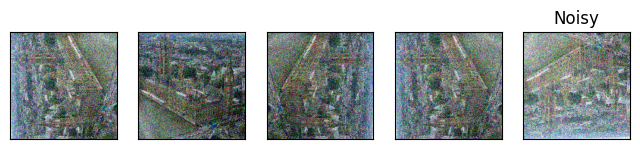

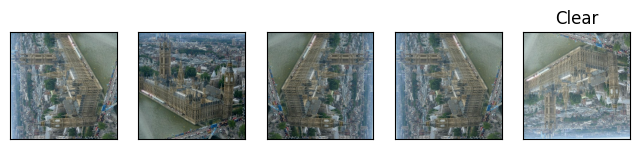

In [82]:
display_image(x_train, 5, 'Noisy')
display_image(y_train, 5, 'Clear')

### Model

In [83]:
def save_model_scores(model_name, optimizer, loss, history):
    filepath = os.path.join(ROOT, f"{PROJECT}.csv")

    exists = os.path.exists(filepath)

    with open(filepath, 'a', newline='') as file:
        writer = csv.writer(file)

        if not exists:
            header = ["model", "optimizer", "loss", "noise_factor", "seed", "batch_size", "epoch", "train_loss",
                      "val_loss", "train_accuracy", "val_accuracy", "train_ssim", "val_ssim"]
            writer.writerow(header)

        for i in range(len(history.history["loss"])):
            row = [
                str(model_name),
                str(optimizer),
                str(loss),
                float(NOISE_FACTOR),
                int(SEED),
                int(BATCH_SIZE),
                str(f"{i + 1}/{NB_EPOCHS}"),
                float(history.history["loss"][i]),
                float(history.history["val_loss"][i]),
                float(history.history["accuracy"][i]),
                float(history.history["val_accuracy"][i]),
                float(history.history["ssim_loss"][i]),
                float(history.history["val_ssim_loss"][i]),
            ]
            writer.writerow(row)

In [84]:
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

#### Define model

In [85]:
from tensorflow.keras import layers, models

def build_autoencoder(input_shape):
    # Encoder
    encoder = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(256, (5, 5), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Conv2D(128, (5, 5), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Dropout(0.3),
    ], name='encoder')

    # Decoder
    decoder = models.Sequential([
        layers.Conv2DTranspose(128, kernel_size=(5, 5), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.UpSampling2D((2, 2)),
        layers.Conv2DTranspose(256, kernel_size=(5, 5), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.UpSampling2D((2, 2)),
        layers.Conv2DTranspose(3, kernel_size=(3, 3), activation='sigmoid', padding='same'),
    ], name='decoder')

    # Combine encoder and decoder to create the autoencoder
    autoencoder = models.Sequential([
        encoder,
        decoder
    ], name='autoencoder')

    return autoencoder


In [86]:
# Build the autoencoder model
autoencoder = build_autoencoder(INPUT_SHAPE)

In [87]:
optimizer = "Adadelta "
loss = "SSIM"

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=ssim_loss,
    metrics=['accuracy', ssim_loss],
)

#### Save model

#### Checkpoint callback

#### Early Stopping callback

In [88]:
print(PATIENCE)

200


In [89]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_ssim_loss',
    mode='min',
    patience=400,
    restore_best_weights=True
)

### Train

In [90]:
# Train the model
history = autoencoder.fit(
    tf.data.Dataset.zip((x_train, y_train)),
    epochs=NB_EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=tf.data.Dataset.zip((x_test, y_test)),
    callbacks=[early_stopping_callback]
)

Epoch 1/500


2023-10-21 16:33:40.477513: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder/encoder/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


120/120 [==============================] - 36s 266ms/step - loss: 0.5987 - accuracy: 0.3388 - ssim_loss: 0.5987 - val_loss: 0.6602 - val_accuracy: 0.1787 - val_ssim_loss: 0.6602
Epoch 2/500
120/120 [==============================] - 31s 255ms/step - loss: 0.5138 - accuracy: 0.3736 - ssim_loss: 0.5138 - val_loss: 0.6371 - val_accuracy: 0.1907 - val_ssim_loss: 0.6371
Epoch 3/500
120/120 [==============================] - 30s 247ms/step - loss: 0.4821 - accuracy: 0.4207 - ssim_loss: 0.4821 - val_loss: 0.5825 - val_accuracy: 0.3951 - val_ssim_loss: 0.5825
Epoch 4/500
120/120 [==============================] - 30s 249ms/step - loss: 0.4631 - accuracy: 0.4521 - ssim_loss: 0.4631 - val_loss: 0.5469 - val_accuracy: 0.6324 - val_ssim_loss: 0.5469
Epoch 5/500
120/120 [==============================] - 29s 243ms/step - loss: 0.4582 - accuracy: 0.4566 - ssim_loss: 0.4582 - val_loss: 0.5669 - val_accuracy: 0.5853 - val_ssim_loss: 0.5669
Epoch 6/500
120/120 [==============================] - 29s 243

#### Save training

#### Show model statistics

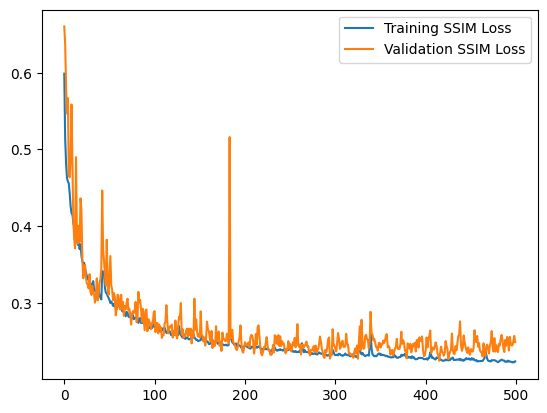

In [91]:
if history.history["ssim_loss"]:
    plt.plot(history.history["ssim_loss"], label="Training SSIM Loss")
    plt.plot(history.history["val_ssim_loss"], label="Validation SSIM Loss")
    plt.legend()

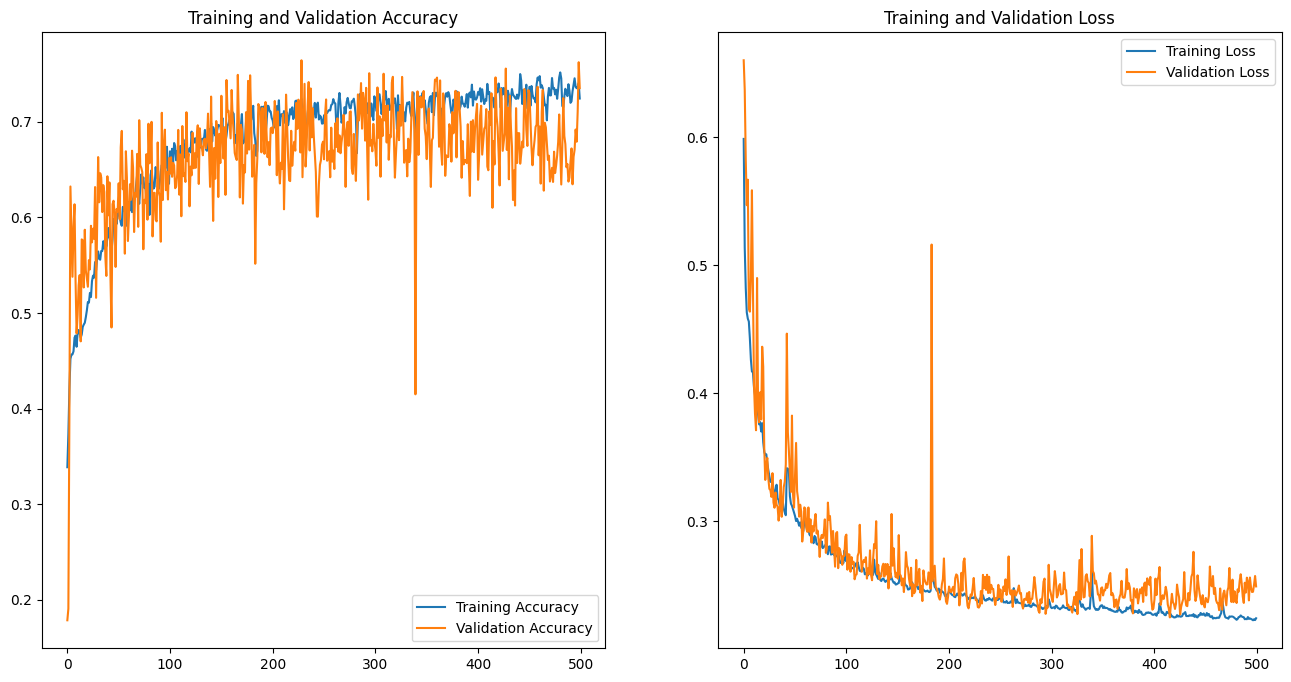

In [92]:
epochs_range = range(len(history.history['loss']))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

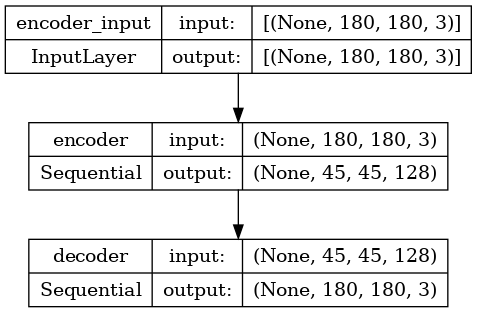

In [93]:
tf.keras.utils.plot_model(autoencoder, show_shapes=True)

In [94]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 45, 45, 128)       840320    
                                                                 
 decoder (Sequential)        (None, 180, 180, 3)       1237635   
                                                                 
Total params: 2,077,955
Trainable params: 2,076,419
Non-trainable params: 1,536
_________________________________________________________________


In [95]:
#visualkeras.layered_view(autoencoder, to_file=os.path.join(model_checkpoint_path, 'output.png')).show()  # write and show

### Reconstruction

In [96]:
def reconstruct(paths):
    clear_images = []
    noisy_images = []

    i = 0
    for path in paths:
        clear_images.append(load_image(tf.constant(path)))
        noisy_images.append(add_noise(clear_images[i]))
        i += 1

    decoded_images = autoencoder(np.array(noisy_images))

    return clear_images, noisy_images, decoded_images

In [112]:
clear_images, noisy_images, decoded_images = reconstruct([
    os.path.join(ROOT, '/kaggle/input/datasetlivrable2/Dataset/noisy_025.jpg'),
    os.path.join(ROOT, '/kaggle/input/datasetlivrable2/Dataset/noisy_028.jpg'),
    os.path.join(ROOT, '/kaggle/input/datasetlivrable2/Dataset/noisy_033.jpg')
])

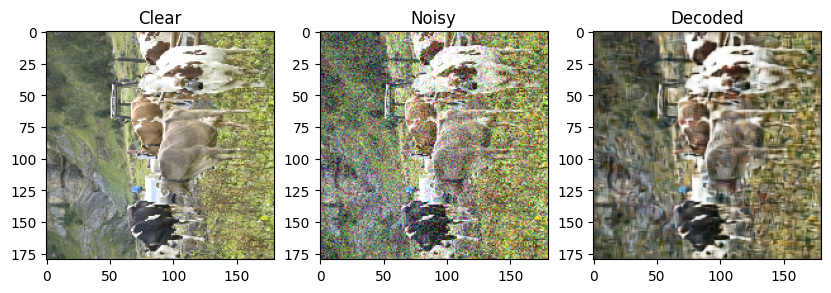

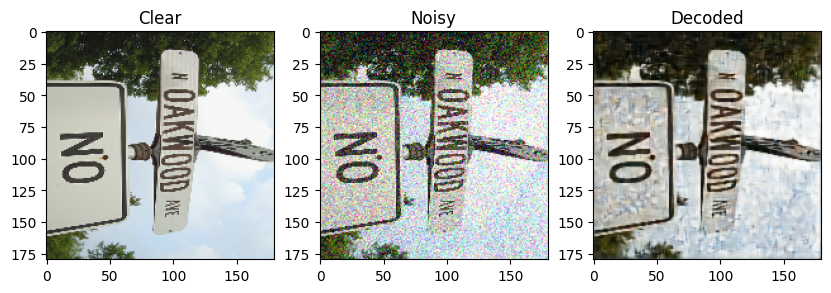

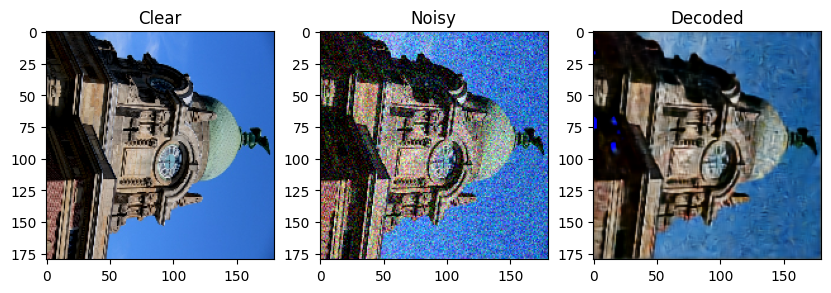

In [113]:
for i in range(len(decoded_images)):
    plt.figure(figsize=(10, 10))

    plt.subplot(131)
    plt.imshow(clear_images[i])
    plt.title('Clear')

    plt.subplot(132)
    plt.imshow(noisy_images[i])
    plt.title('Noisy')

    decoded = tf.clip_by_value(decoded_images[i], 0., 1.)

    plt.subplot(133)
    plt.imshow(decoded)
    plt.title('Decoded')

plt.show()

In [107]:
# reconstructions = autoencoder.predict(tf.expand_dims(img_noisy, axis=0))
# train_loss = tf.keras.losses.mae(reconstructions, x_train)
#
# plt.hist(train_loss[None,:], bins=50)
# plt.xlabel("Train loss")
# plt.ylabel("No of examples")
# plt.show()